<a href="https://colab.research.google.com/github/GreatGameDota/PANDA-Challenge-Solution/blob/master/training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#### .

In [ ]:
%%writefile setup.sh

git clone https://github.com/NVIDIA/apex
pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./apex

In [ ]:
import os
if not os.path.isdir('apex/'):
  !sh setup.sh

#### Download data

In [ ]:
import json
import zipfile
import os
os.chdir('/content')

!pip install kaggle --quiet

api_token = {"username":"greatgamedota","key":""} # Get the key from create new api token on https://www.kaggle.com/greatgamedota/account
!mkdir /root/.kaggle # create a dir for key
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json # make sure no one else can read the key

if not os.path.isdir('train_images/') and not os.path.isdir('train/'):
  !kaggle competitions download -c prostate-cancer-grade-assessment --quiet
  !rm *.tiff.zip
  !rm *.tiff
  !rm train.csv
  
  !kaggle datasets download -d lopuhin/panda-2020-level-1-2
  !unzip -q panda-2020-level-1-2.zip
  !rm panda-2020-level-1-2.zip

#### .

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm,trange
from sklearn.model_selection import train_test_split
import sklearn.metrics
import scipy as sp

import torch
import torch.nn as nn
import torch.nn.functional as F
# from torch.cuda import amp

from apex import amp

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import cohen_kappa_score

def quadratic_weighted_kappa(y_hat, y):
    return cohen_kappa_score(y_hat, y, weights='quadratic')

class config:
    epochs = 15
    batch_size = 4
    regression = False
    num_classes = 6 - 1
    IMAGE_PATH = 'train_images/train_images/'
    lr = 1e-4
    # lr = 3e-4
    N = 36
    sz = 256
    mean = [1.0-0.90949707, 1.0-0.8188697, 1.0-0.87795304],
    std = [0.36357649, 0.49984502, 0.40477625],
    seed = 42
    mixup = 0
    cutmix = 0
    accumulation_steps = 1
    single_fold = 1

import random
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(config.seed)

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
mskf = StratifiedKFold(n_splits=5, random_state=config.seed, shuffle=True)

train_df2 = pd.read_csv('train.csv')
# train_df2 = train_df2.sample(frac=1).reset_index(drop=True)
train_df2 = train_df2.drop(['gleason_score'], axis=1)

# Remove blank image
train_df2 = train_df2[train_df2['image_id']!='3790f55cad63053e956fb73027179707'].reset_index(drop=True)

X, y = train_df2.values[:,0:2], train_df2[['isup_grade']].values[:,0]

train_df2['fold'] = -1
for fld, (_, test_idx) in enumerate(mskf.split(X, y)):
    train_df2.iloc[test_idx, -1] = fld

#### Dataset

In [ ]:
# Kindly stolen from @iafoss: https://www.kaggle.com/iafoss/panda-16x128x128-tiles
def tile(img):
    sz = config.sz
    N = config.N
    result = []
    shape = img.shape
    pad0,pad1 = (sz - shape[0]%sz)%sz, (sz - shape[1]%sz)%sz
    img = np.pad(img,[[pad0//2,pad0-pad0//2],[pad1//2,pad1-pad1//2],[0,0]],
                constant_values=255)
    img = img.reshape(img.shape[0]//sz,sz,img.shape[1]//sz,sz,3)
    img = img.transpose(0,2,1,3,4).reshape(-1,sz,sz,3)
    if len(img) < N:
        img = np.pad(img,[[0,N-len(img)],[0,0],[0,0],[0,0]],constant_values=255)
    idxs = np.argsort(img.reshape(img.shape[0],-1).sum(-1))[:N]
    imgs = img[idxs]
    result = []
    for i in range(len(imgs)):
        result.append({'img':imgs[i], 'idx':i})
    return result

from torch.utils.data import Dataset, DataLoader
from PIL import Image

class ImageDataset(Dataset):
    def __init__(self, dataframe, root_dir, folds, transform=None, transform2=None, mode='train'):
        self.df = dataframe[dataframe.fold.isin(folds).reset_index(drop=True)]
        self.root_dir = root_dir
        self.transform = transform
        self.transform2 = transform2
        self.folds = folds
        self.mode = mode

        self.paths = self.df.image_id.values
        self.labels = self.df.values[:,2]

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_name = self.paths[idx]
        imgs = []
        img_path = f'{self.root_dir}{img_name}_1.jpeg'
        img = cv2.imread(img_path)
        if img is None:
          print(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        sz = config.sz
        imgs = [img_['img'] for img_ in tile(img)]
        imgs = [(255 - img).astype(np.float32) / 255. for img in imgs]
        # imgs = [(255 - img).astype(np.float32) for img in imgs]
        
        if self.transform is not None:
          imgs = [self.transform(image=img)['image'] for img in imgs]
        
        imgs = np.array(imgs)
        # imgs = np.hstack(imgs)
        idx_ = 0
        img_ = []
        for i in range(6): #vertical
          img = []
          for j in range(6): #horizontal
              img.append(imgs[idx_])
              idx_+=1
          img_.append(np.hstack(np.array(img)))
        imgs = np.vstack(np.array(img_))
        
        if self.transform2 is not None:
          imgs = self.transform2(image=imgs)['image']
        # imgs = (255 - imgs).astype(np.float32) / 255.
        imgs = np.rollaxis(imgs, -1, 0)

        labels = np.array(self.labels[idx]).astype(np.long)
        
        arr = np.zeros((config.num_classes))
        for i in range(labels):
          arr[i] = 1
        
        labels_ = np.array(arr)
        return [imgs, labels_]

#### Model

In [ ]:
!pip install pytorchcv --quiet
!pip install timm --quiet
import timm
from pytorchcv.model_provider import get_model

from torch.nn.parameter import Parameter
def gem(x, p=3, eps=1e-6):
    return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)
class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM,self).__init__()
        self.p = Parameter(torch.ones(1)*p)
        self.eps = eps
    def forward(self, x):
        return gem(x, p=self.p, eps=self.eps)       
    def __repr__(self):
        return self.__class__.__name__ + '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + ', ' + 'eps=' + str(self.eps) + ')'

class MishFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        ctx.save_for_backward(x)
        return x * torch.tanh(F.softplus(x))   # x * tanh(ln(1 + exp(x)))

    @staticmethod
    def backward(ctx, grad_output):
        x = ctx.saved_variables[0]
        sigmoid = torch.sigmoid(x)
        tanh_sp = torch.tanh(F.softplus(x)) 
        return grad_output * (tanh_sp + x * sigmoid * (1 - tanh_sp * tanh_sp))

class Mish(nn.Module):
    def forward(self, x):
        return MishFunction.apply(x)

def to_Mish(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.ReLU):
            setattr(model, child_name, Mish())
        else:
            to_Mish(child)

class Pooling(nn.Module):
  def __init__(self):
    super(Pooling, self).__init__()
    
    self.p1 = nn.AdaptiveAvgPool2d(1)
    self.p2 = nn.AdaptiveMaxPool2d(1)

  def forward(self, x):
    x1 = self.p1(x)
    x2 = self.p2(x)
    return (x1+x2) * 0.5

class Head(torch.nn.Module):
  def __init__(self, in_f, out_f, dropout):
    super(Head, self).__init__()
    
    self.f = nn.Flatten()
    self.l = nn.Linear(in_f, 512)
    self.m = Mish()
    self.r = nn.ReLU()
    self.d = nn.Dropout(0.5)
    self.dropout = dropout
    # self.o = nn.Linear(512, out_f)
    self.o = nn.Linear(in_f, out_f)
    self.b1 = nn.BatchNorm1d(in_f)
    self.b2 = nn.BatchNorm1d(512)

  def forward(self, x):
    x = self.f(x)
    # x = self.b1(x)
    if self.dropout:
      x = self.d(x)

    # x = self.l(x)
    # x = self.r(x)
    # x = self.b2(x)
    # if self.dropout:
    #   x = self.d(x)

    out = self.o(x)
    return out

class FCN(torch.nn.Module):
  def __init__(self, base, in_f, num_classes, dropout=True):
    super(FCN, self).__init__()
    self.base = base
    self.h1 = Head(in_f, num_classes, dropout)
  
  def forward(self, x):
    # shape = x.shape
    # x = torch.stack(x,1).view(-1,shape[1],shape[2],shape[3])
    # x = x.view(config.N*shape[0],shape[4],shape[2],shape[3])
    # print(x.shape)
    x = self.base(x)
    # shape = x.shape
    # print(x.shape)
    # x = x.view(-1,n,shape[1],shape[2],shape[3]).permute(0,2,1,3,4).contiguous().view(-1,shape[1],shape[2]*config.N,shape[3])
    x = self.h1(x)
    return x

def create_model(name):
    model = get_model(name, pretrained=True)
    # model = timm.create_model(name, pretrained=True)
    try:
      features = list(model.children())[-1].in_features
    except:
      features = list(model.children())[-1][-1].in_features
    model = nn.Sequential(*list(model.children())[:-1]) # Remove original output layer
    # model[0].final_pool = nn.Sequential(nn.AdaptiveAvgPool2d(1))
    model[0].final_pool = nn.Sequential(GeM())
    # model[-1] = nn.Sequential(GeM())
    model = FCN(model, features, config.num_classes, dropout=True)
    return model

model = create_model("efficientnet_b1")
model.parameters

#### Train funcs

In [ ]:
def criterion1(pred1, targets):
  if config.regression:
    l1 = F.mse_loss(pred1, targets)
    # l1 = F.smooth_l1_loss(pred1, targets)
  else:
    # l1 = F.cross_entropy(pred1, targets)
    l1 = F.binary_cross_entropy_with_logits(pred1, targets)
  return l1

def train_model(epoch, optimizer, scaler=None, scheduler=None, history=None):
    model.train()
    total_loss = 0
    
    # optimizer.zero_grad()

    t = tqdm(train_loader)
    for batch_idx, (img_batch, y_batch) in enumerate(t):
        img_batch = img_batch.cuda().float()
        if config.regression:
          y_batch = y_batch.cuda().float()
        else:
          y_batch = y_batch.cuda()
        
        # optimizer.zero_grad()
        
        rand = np.random.rand()
        if rand < config.mixup:
            pass
            # images, targets = mixup(img_batch, y_batch, 0.4)
            # output1 = model(images)
            # loss = mixup_criterion(output1, targets)
        elif rand < config.cutmix:
            pass
            # images, targets = cutmix(img_batch, y_batch, 0.4)
            # output1 = model(images)
            # loss = cutmix_criterion(output1, targets)
        else:
            # with amp.autocast():
            output1 = model(img_batch)
            loss = criterion1(output1, y_batch) / config.accumulation_steps
            # loss = criterion1(output1, y_batch)

        # total_loss += loss.data.cpu().numpy()
        total_loss += loss.data.cpu().numpy() * config.accumulation_steps
        t.set_description(f'Epoch {epoch+1}/{n_epochs}, LR: %6f, Loss: %.4f'%(optimizer.state_dict()['param_groups'][0]['lr'],total_loss/(batch_idx+1)))

        if history is not None:
          history.loc[epoch + batch_idx / len(train_loader), 'train_loss'] = loss.data.cpu().numpy()
          history.loc[epoch + batch_idx / len(train_loader), 'lr'] = optimizer.state_dict()['param_groups'][0]['lr']
        
        # scaler.scale(loss).backward()
        # loss.backward()
        with amp.scale_loss(loss, optimizer) as scaled_loss:
          scaled_loss.backward()
        
        if (batch_idx+1) % config.accumulation_steps == 0:
          # scaler.step(optimizer)
          optimizer.step()
          # scaler.update()
          optimizer.zero_grad()
        
        if scheduler is not None:
          scheduler.step(epoch)

def evaluate_model(epoch, scheduler=None, history=None):
    model.eval()
    loss = 0
    
    preds_1 = []
    tars_1 = []
    with torch.no_grad():
        # t = tqdm(val_loader)
        for img_batch, y_batch in val_loader:
            img_batch = img_batch.cuda().float()
            if config.regression:
              y_batch = y_batch.cuda().float()
            else:
              y_batch = y_batch.cuda()

            o1 = model(img_batch)

            l1 = criterion1(o1, y_batch)
            loss += l1

            for j in range(len(o1)):
              if config.regression:
                # preds_1.append(np.round(np.clip(o1[j].cpu(), 0, config.num_classes-1)))
                preds_1.append(o1[j].cpu())
              else:
                # preds_1.append(torch.argmax(F.softmax(o1[j]), -1))
                preds_1.append(len(np.where(np.round(F.sigmoid(o1[j]).cpu())==1)[0]))
            for i in y_batch:
              # tars_1.append(i.data.cpu().numpy())
              tars_1.append(len(np.where(i.cpu()==1)[0]))
    
    # preds_1 = [p.data.cpu().numpy() for p in preds_1]
    preds_1 = np.array(preds_1).T.reshape(-1)
    
    acc = sklearn.metrics.recall_score(tars_1, preds_1, average='macro')
    final_score = quadratic_weighted_kappa(tars_1, preds_1)
    
    loss /= len(val_loader)
    
    if history is not None:
      history.loc[epoch, 'val_loss'] = loss.cpu().numpy()
      history.loc[epoch, 'acc'] = acc
      history.loc[epoch, 'qwk'] = final_score
    
    if scheduler is not None:
      scheduler.step(final_score)

    if config.regression:
      print(f'Dev loss: %.4f, QWK: {final_score}, Acc: {acc}'%(loss))
      # print(f'Thresholds: {coefficients}')
    else:
      print(f'Dev loss: %.4f, QWK: {final_score}, Acc: {acc}'%(loss))
    
    with open(log_name, 'a') as f:
      f.write(f'XXXXXXXXXXXXXX-- CYCLE INTER: {epoch+1} --XXXXXXXXXXXXXXXXXXX\n')
      f.write(f'val epoch: {epoch+1}\n')
      f.write(f'val loss: {loss}  val acc: {acc}\n')
      f.write(f'val QWK: {final_score}\n')
      f.write('\n')

    return loss, final_score

#### Dataset

In [ ]:
!pip install albumentations==0.4.3 --quiet
import albumentations as A

train_transform = A.Compose([
                             A.CoarseDropout(max_holes=4, max_height=16, max_width=16, p=0.9),
                             A.OneOf([
                              A.ShiftScaleRotate(scale_limit=.15, rotate_limit=20, border_mode=cv2.BORDER_CONSTANT, p=1),
                              A.IAAAffine(rotate=20, shear=20, mode='constant', p=1),
                              A.IAAPerspective(p=1),
                             ], p=0.9),
                             A.Transpose(p=0.5),
                             A.VerticalFlip(p=0.5),
                             A.HorizontalFlip(p=0.5),
])

train_transform2 = A.Compose([
                              A.RandomBrightnessContrast(p=0.5),
                              A.Transpose(p=0.5),
                              A.HorizontalFlip(p=0.5),                           
                              A.VerticalFlip(p=0.5),
])

val_transform = A.Compose([
                          # A.Normalize(mean=config.mean, std=config.std, always_apply=True)
])

fold = 0
folds = [0,1,2,3,4]
train_dataset = ImageDataset(train_df2, config.IMAGE_PATH, folds=[i for i in folds if i != fold], transform=train_transform, transform2=train_transform2)

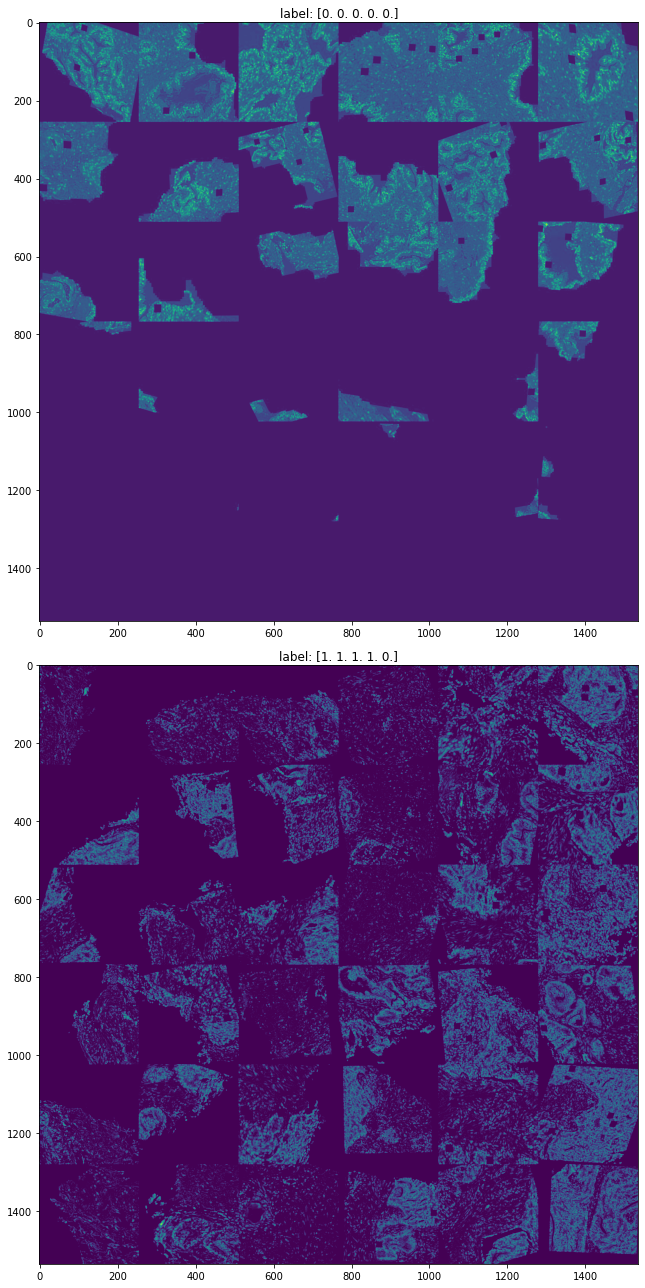

In [ ]:
nrow, ncol = 2, 1
fig, axes = plt.subplots(nrow, ncol, figsize=(20, 18))
axes = axes.flatten()
for i, ax in enumerate(axes):
    image, label = train_dataset[i]
    # image = np.rollaxis(image, 0, 3)
    ax.imshow(image[0])
    ax.set_title(f'label: {label}')
plt.tight_layout()

#### Training

In [ ]:
import gc

folds = [0,1,2,3,4]
validations = []

log_name = f"drive/My Drive/logs/log-{len(os.listdir('drive/My Drive/logs/'))}.log"

for fold in range(1):
  fold = config.single_fold
  
  print(f'Train Fold {fold+1}')
  with open(log_name, 'a') as f:
    f.write(f'Train Fold {fold+1}\n\n')

  history = pd.DataFrame()
  history2 = pd.DataFrame()

  torch.cuda.empty_cache()
  gc.collect()

  best = 0
  best2 = 1e10
  n_epochs = config.epochs
  early_epoch = 0

  train_dataset = ImageDataset(train_df2, config.IMAGE_PATH, folds=[i for i in folds if i != fold], transform=train_transform)
  val_dataset = ImageDataset(train_df2, config.IMAGE_PATH, folds=[fold], transform=val_transform, mode='val')

  BATCH_SIZE = config.batch_size
  
  train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
  val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

  # scaler = amp.GradScaler()

  # model = create_model("seresnext50_32x4d")
  model = create_model("efficientnet_b1")
  # model = create_model("resnet34")
  model = model.cuda()

  optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)
  
  model, optimizer = amp.initialize(model, optimizer, opt_level='O1', verbosity=0)
  
  # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, mode='max', factor=0.75, verbose=True, min_lr=1e-5)
  # scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001, steps_per_epoch=len(train_loader), epochs=n_epochs)
  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs, eta_min=1e-5) # step with epoch #

  for epoch in range(n_epochs-early_epoch):
      epoch += early_epoch
      torch.cuda.empty_cache()
      gc.collect()

      train_model(epoch, optimizer, scaler=None, scheduler=scheduler, history=history)
      
      loss, kaggle = evaluate_model(epoch, scheduler=None, history=history2)
      # break
      if kaggle > best:
        best = kaggle
        print(f'Saving best model... (qwk)')
        torch.save({
          'model_state': model.state_dict(),
        }, f'drive/My Drive/Models/model-fld{fold+1}.pth')
  print()
  validations.append(best)

validations = np.array(validations)
for i,val in enumerate(validations):
    print(f'Fold {i+1}: {val}')
print(f'5fold CV: {np.mean(validations)}')

In [ ]:
history2['qwk'].plot()

In [ ]:
# drive.flush_and_unmount()